## Paczki

Podstawowy model do kolorowania

In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from pytorch_lightning.callbacks import ModelCheckpoint
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.notebook import tqdm, trange
from pytorch_lightning.tuner.tuning import Tuner

In [3]:
TRAIN_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/train'
VAL_IMG_DIR = '../../imagenet/colorized_imagenet/colorized_imagenet_demo/val'
TARGET_DIR = '../../imagenet/colorization_dataset_imagenet/'
TARGET_TRAIN_DIR = os.path.join(TARGET_DIR, 'train')
TARGET_VAL_DIR = os.path.join(TARGET_DIR, 'val')
CHECKPOINT_PATH = '/tmp/checkpoints'
CLASSES_PATH = '../data/used_ab_pairs.txt'
MODEL_PATH = '/tmp'
SAMPLE_SIZE = -1
BATCH_SIZE = 16
LEARNING_RATE = 1e-2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

## Zbiór danych - wstępna analiza

In [4]:
# def combine_l_ab(l : torch.Tensor, ab : torch.Tensor, ab_pairs_classes) -> np.ndarray:

#     # if not batched then add batch dimension
#     if l.ndim == 3:
#         l = l.unsqueeze(0)
#         ab = ab.unsqueeze(0)

#     # ab is index for NUM_CLASSES bins

#     lab_image_tensor = torch.cat((l, ab), dim=1)  # Shape: [1, 3, H, W]

#     lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

#     # **Fix LAB ranges for OpenCV**
#     # Ensure L is in [0, 255]
#     lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

#     # Ensure A and B are centered around 128 and within [0, 255]
#     lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

#     # Convert LAB back to RGB
#     rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

#     return rgb_image

## Kolory

In [5]:
AB_NORM = 255.0

In [6]:
def generate_ab_pairs(grid_size=10, luminance=50):
    """Generate 313 quantized ab pairs that are within the RGB gamut."""

    a_range = np.arange(0, AB_NORM, grid_size)
    b_range = np.arange(0, AB_NORM, grid_size)
    ab_grid = np.array(np.meshgrid(a_range, b_range)).T.reshape(-1, 2)

    valid_ab = set()

    for ab in ab_grid:
        a,b = ab
        lab_color = np.array([[luminance, a, b]], dtype=np.float32)

        rgb_color = cv2.cvtColor(lab_color[None, :, :], cv2.COLOR_LAB2RGB)[0, 0, :]

        if np.all(rgb_color >= 0) and np.all(rgb_color <= 1):
            valid_ab.add((a, b))
    
    return valid_ab

In [7]:
def get_nearest_bin(ab, grid_size=10):
    """Get the nearest ab bin to the given ab value.
    ab: Tuple of (a, b) values.
    """
    a, b = ab

    nearest_a = round(a / grid_size) * grid_size
    nearest_b = round(b / grid_size) * grid_size

    return (nearest_a, nearest_b)

In [8]:
from collections import Counter

In [9]:
used_ab_pairs = []
with open(CLASSES_PATH, 'r') as f:
    for line in f:
        a, b = line.strip().split(',')
        used_ab_pairs.append((int(a), int(b)))

In [10]:
NUM_CLASSES = 200

In [11]:
# take most common NUM_CLASSES colors from the used_ab_pairs

used_ab_pairs = Counter(used_ab_pairs).most_common(NUM_CLASSES)
used_ab_pairs = [pair[0] for pair in used_ab_pairs]

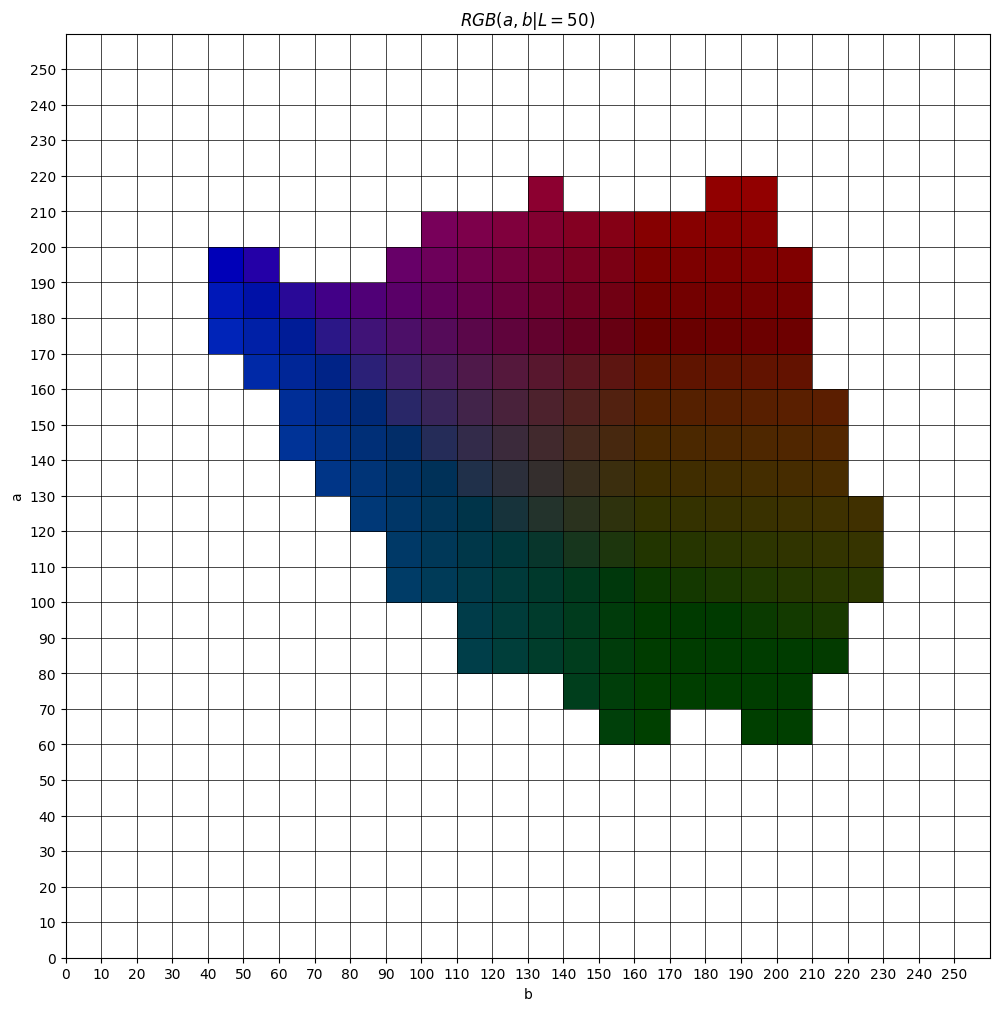

In [12]:
def plot_ab_color_map_matshow(ab_pairs, L=50, grid_size=10):
    """Plot a 2D color map for the ab space using the provided ab pairs with matshow."""

    a_range = np.arange(0, AB_NORM, grid_size)
    b_range = np.arange(0, AB_NORM, grid_size)
    ab_grid = np.array(np.meshgrid(a_range, b_range)).T.reshape(-1, 2)

    color_grid = {
        (a, b): [255, 255, 255] for a, b in ab_grid
    }
    
    for ab in ab_pairs:
        a, b = ab

        lab_color = np.array([L, a, b], dtype=np.uint8)
        
        # ensure L is in [0, 255]
        lab_color[0] = np.clip(lab_color[0], 0, 255)

        # Ensure A and B are centered around 128 and within [0, 255]
        lab_color[1:] = np.clip(lab_color[1:], 0, 255)

        rgb_color = cv2.cvtColor(
            lab_color[None, None, :].astype(np.uint8),
            cv2.COLOR_LAB2RGB
        )

        # check if the color is within the RGB gamut
        if np.all(rgb_color >= 0) and np.all(rgb_color <= 255):
            # rgb_color = (rgb_color * 255).astype(np.uint8)[0, 0, :]
            color_grid[(a, b)] = rgb_color

        color_grid[(a, b)] = rgb_color

    len_grid_range = len(a_range)

    rgb_array = np.full((len_grid_range, len_grid_range, 3), 255, dtype=np.uint8)
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            rgb_array[i, j, :] = color_grid[(a, b)]


    plt.figure(figsize=(12, 12))
    plt.imshow(
        rgb_array,
        origin="lower",
        extent=(0, len_grid_range, 0, len_grid_range),
    )
    plt.xlabel("b")
    plt.ylabel("a")
    plt.title(r"$RGB(a, b | L=50)$")

    plt.grid(color="black", linestyle="-", linewidth=0.5)

    tick_positions = np.arange(0, len_grid_range, 1).astype(np.uint8)
    tick_labels = np.arange(0, AB_NORM, grid_size).astype(np.uint8)

    plt.xticks(tick_positions, labels=tick_labels)
    plt.yticks(tick_positions, labels=tick_labels)

# plot_ab_color_map_matshow(ab_pairs)
plot_ab_color_map_matshow(used_ab_pairs)

In [13]:
def one_hot_encode_ab_pairs(ab_tensor, used_ab_pairs, grid_size=10):
    """
    Convert ab values to one-hot encoded tensor based on the closest used_ab_pairs.

    Args:
        ab_tensor (torch.Tensor): Tensor of shape (batch, h, w, 2) containing ab values.
        used_ab_pairs (list): List of used ab pairs.
        grid_size (int): Grid size for quantization.

    Returns:
        torch.Tensor: One-hot encoded tensor of shape (batch, h, w, len(used_ab_pairs)).
    """
    batch, h, w, _ = ab_tensor.shape
    num_classes = len(used_ab_pairs)

    assert ab_tensor.shape[3] == 2, "ab_tensor must have 2 channels."
    assert num_classes == NUM_CLASSES, "Number of classes must match the number of used ab pairs."
    assert h == IMAGE_HEIGHT and w == IMAGE_WIDTH, "Height and width must match the image dimensions."
    
    # Create a tensor to hold the one-hot encoded values
    one_hot_tensor = torch.zeros((batch, h, w, num_classes), dtype=torch.float32)

    # Convert used_ab_pairs to a list of tuples for easy indexing
    used_ab_pairs_list = list(used_ab_pairs)

    # Create a dictionary to map ab pairs to their indices
    ab_pair_to_index = {ab_pair: idx for idx, ab_pair in enumerate(used_ab_pairs_list)}

    # print(ab_tensor.shape)

    # Iterate over each pixel in the batch
    for b in range(batch):
        for i in range(h):
            for j in range(w):
                ab_value = ab_tensor[b, i, j].numpy()
                nearest_bin = get_nearest_bin(ab_value, grid_size)
                if nearest_bin in ab_pair_to_index:
                    one_hot_tensor[b, i, j, ab_pair_to_index[nearest_bin]] = 1.0
                else:
                    raise ValueError(f"Nearest bin not found: {nearest_bin}")

    assert torch.all(one_hot_tensor.sum(dim=-1) == 1.0), "One-hot tensor is not correctly encoded."
    
    return one_hot_tensor


## Wagi do rebalansingu

In [14]:
from scipy.ndimage import gaussian_filter1d

In [15]:
# load ab_pair_counter from ../data/ab_pair_counter.txt

ab_pair_counter = Counter()
with open('../data/ab_pair_counter.txt', 'r') as f:
    for line in f:
        a, b, count = line.strip().split(',')
        ab_pair_counter[(int(a), int(b))] = int(count)


In [16]:
def compute_weights_from_pairs(used_ab_pairs, ab_pair_counter, sigma=5, lambda_factor=0.5):
    """
    Compute class-rebalancing weights from used_ab_pairs and ab_pair_counter.

    Args:
        used_ab_pairs (list): List of quantized ab pairs for each class.
        ab_pair_counter (Counter): Counter with quantized ab pair counts.
        sigma (float): Standard deviation for Gaussian smoothing.
        lambda_factor (float): Mixing factor for uniform distribution.

    Returns:
        torch.Tensor: Class weights of shape [num_classes].
    """
    num_classes = len(used_ab_pairs)

    # Initialize counts for each class
    class_counts = np.zeros(num_classes, dtype=np.float32)

    # Populate counts using ab_pair_counter
    for idx, ab_pair in enumerate(used_ab_pairs):
        class_counts[idx] = ab_pair_counter.get(ab_pair, 0)

    # Compute empirical probabilities
    total_count = class_counts.sum()
    empirical_probs = class_counts / total_count if total_count > 0 else class_counts

    # Smooth the empirical probabilities using Gaussian filtering
    smoothed_probs = gaussian_filter1d(empirical_probs, sigma=sigma)

    # Mix with uniform distribution
    uniform_probs = np.ones_like(smoothed_probs) / num_classes
    mixed_probs = (1 - lambda_factor) * smoothed_probs + lambda_factor * uniform_probs

    # Compute weights (reciprocal of the mixed probabilities)
    weights = 1 / (mixed_probs + 1e-10)  # Avoid division by zero

    # Normalize weights so their expectation is 1
    normalized_weights = weights / (weights @ empirical_probs)

    return torch.tensor(normalized_weights, dtype=torch.float32)

In [17]:
rebalancing_weights = compute_weights_from_pairs(used_ab_pairs, ab_pair_counter, sigma=1)

## Zbiór danych treningowych

In [18]:
class AutoColorizationDatasetFromTorchFiles(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.num_classes = len(used_ab_pairs)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        input_l = torch.load(img_path, weights_only=True)
        target = torch.load(label_path, weights_only=True)

        assert input_l.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH), "Input L shape is incorrect."
        assert target.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

        return input_l, target

In [19]:
soft_encoding_sigma = 2

In [20]:
from scipy.spatial.distance import cdist

class SoftEncodedAutoColorizationDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.num_classes = len(used_ab_pairs)
        self.used_ab_pairs = torch.tensor(used_ab_pairs, dtype=torch.float32)
        self.sigma = soft_encoding_sigma

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        input_l = torch.load(img_path, weights_only=True)
        target = torch.load(label_path, weights_only=True)

        assert input_l.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH), "Input L shape is incorrect."
        assert target.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

        # TODO
        # if target > NUM_CLASSES then set it to the last class
        target = torch.clamp(target, 0, self.num_classes - 1)

        target_soft = self.soft_encode(target)

        return input_l, target_soft

    def soft_encode(self, target_indices):
        """
        Convert target indices to soft-encoded targets using Gaussian smoothing.

        Args:
            target_indices (torch.Tensor): Ground truth class indices, shape [H, W].

        Returns:
            torch.Tensor: Soft-encoded targets, shape [NUM_CLASSES, H, W].
        """
        h, w = target_indices.shape
        target_flat = target_indices.view(-1)  # Flatten to [H * W]

        # Pairwise distances between target pixels and ab bins
        distances = cdist(
            self.used_ab_pairs.numpy(),
            self.used_ab_pairs[target_flat].numpy(),
        ).T  # [H * W, NUM_CLASSES]

        top5_indices = np.argsort(distances, axis=1)[:, :5]  # [H * W, 5]
        top5_distances = np.take_along_axis(distances, top5_indices, axis=1)  # [H * W, 5]

        distances = torch.tensor(top5_distances, dtype=torch.float32)

        # Apply Gaussian smoothing
        weights = torch.exp(-(distances ** 2) / (2 * self.sigma ** 2))  # [H * W, NUM_CLASSES]
        weights /= weights.sum(dim=1, keepdim=True)  # Normalize to probabilities

        soft_encoded = np.zeros((target_flat.numel(), self.num_classes), dtype=np.float32)  # [H * W, NUM_CLASSES]
        np.put_along_axis(soft_encoded, top5_indices, weights, axis=1)

        # Reshape back to [NUM_CLASSES, H, W]
        return torch.tensor(soft_encoded.T, dtype=torch.float32).view(self.num_classes, h, w)

testin_dataset = SoftEncodedAutoColorizationDataset(
    img_dir=f'{TARGET_TRAIN_DIR}/img',
    label_dir=f'{TARGET_TRAIN_DIR}/label',
)
X, y = testin_dataset[0]

In [21]:
testin_dataset = SoftEncodedAutoColorizationDataset(
    img_dir=f'{TARGET_TRAIN_DIR}/img',
    label_dir=f'{TARGET_TRAIN_DIR}/label',
)

In [22]:
X, y = testin_dataset[0]

In [23]:
y.permute(1, 2, 0)[0][0]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [24]:
# train_dataset = SoftEncodedAutoColorizationDataset(
#     img_dir=f'{TARGET_TRAIN_DIR}/img',
#     label_dir=f'{TARGET_TRAIN_DIR}/label',
# )
# val_dataset = SoftEncodedAutoColorizationDataset(
#     img_dir=f'{TARGET_VAL_DIR}/img',
#     label_dir=f'{TARGET_VAL_DIR}/label',
# )

In [25]:
# X, y = train_dataset[0]

## Modele

In [26]:
class BaseColor(nn.Module):
    """Base class for color normalization and unnormalization."""
    def __init__(self):
        super(BaseColor, self).__init__()
        self.l_cent = 50.0
        self.l_norm = 100.0
        self.ab_norm = 110.0

    def normalize_l(self, in_l):
        return (in_l - self.l_cent) / self.l_norm

    def unnormalize_l(self, in_l):
        return in_l * self.l_norm + self.l_cent

    def normalize_ab(self, in_ab):
        return in_ab / self.ab_norm

    def unnormalize_ab(self, in_ab):
        return in_ab * self.ab_norm
    
    def quantize_ab(self, in_ab):
        # divide ab space, quantize into NUM_CLASSES bins
        return torch.round(in_ab / 10.0)

class ECCVGenerator(BaseColor):
    """Colorization model based on ECCV16 architecture."""
    def __init__(self, norm_layer=nn.BatchNorm2d, num_classes=529):
        super(ECCVGenerator, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, extra_layer=False):
            return [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
            ] if not extra_layer else [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, dilation, bias=True),
                nn.ReLU(inplace=True),
            ]

        def norm_relu_block(channels):
            return [
                nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
                norm_layer(channels),
            ]
        
        self.encoder1 = nn.Sequential(*conv_block(1, 64), *norm_relu_block(64))
        self.encoder2 = nn.Sequential(*conv_block(64, 128), *norm_relu_block(128))
        self.encoder3 = nn.Sequential(*conv_block(128, 256, extra_layer=True), *norm_relu_block(256))
        self.encoder4 = nn.Sequential(*conv_block(256, 512, extra_layer=True), *norm_relu_block(512))
        self.encoder5 = nn.Sequential(*conv_block(512, 512, extra_layer=True, dilation=2, padding=2), *norm_relu_block(512))

        self.bottleneck = nn.Sequential(*conv_block(512, 512, dilation=2, padding=2, extra_layer=True), *norm_relu_block(512))

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(inplace=True),
            *conv_block(256, 256),
            *conv_block(256, 256),
        )

        # multinomial classification into 313 bins of ab color space
        # self.decoder2 = nn.Sequential(
        #     *conv_block(256, 313, kernel_size=1, stride=1, padding=0),
        # )

        self.decoder2 = nn.Sequential(
            *conv_block(256, NUM_CLASSES, kernel_size=1, stride=1, padding=0),
        )


        self.softmax = nn.Softmax(dim=1)
        # self.model_output = nn.Conv2d(313, 2, kernel_size=1, stride=1, padding=0, bias=False)        
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear') # TODO check changed from 4 to 32
        
    def forward(self, input_l):
        """Forward pass of the model.

        Args:
            input_l: L channel of the input image.

        Returns:
            Colorized ab channels.
        """
        # print('Forward pass')
        # print(f'before reshape {input_l.shape}')

        # print(f'normalized {self.normalize_l(input_l).shape}')

        conv1 = self.encoder1(self.normalize_l(input_l))
        conv2 = self.encoder2(conv1)
        conv3 = self.encoder3(conv2)
        conv4 = self.encoder4(conv3)
        conv5 = self.encoder5(conv4)
        bottleneck = self.bottleneck(conv5)
        decv1 = self.decoder1(bottleneck)
        decv2 = self.decoder2(decv1)
        # out = self.model_output(
        #     self.softmax(decv2)
        # )
        out = self.softmax(decv2)
        # print(f'Forward End out {out.shape} ')

        # print(f'returning {self.unnormalize_ab(self.upsample4(out)).shape}')
        # return self.unnormalize_ab(
        #     self.upsample4(out)
        # )
        return self.upsample4(out)

## Pytorch Lightning

In [27]:
class ECCV_LM(pl.LightningModule):
    def __init__(self, learning_rate=1e-2):
        super(ECCV_LM, self).__init__()
        self.model = ECCVGenerator()
        self.criterion = nn.CrossEntropyLoss(weight=rebalancing_weights)
        self.learning_rate = learning_rate

    def forward(self, input_l):
        return self.model(input_l)

    def training_step(self, batch, batch_idx):
        input_l, target_ab = batch

        pred_ab = self(input_l)

        # assert pred_ab.shape == (NUM_CLASSES, IMAGE_HEIGHT, IMAGE_WIDTH), "Prediction shape is incorrect."
        # assert target_ab.shape == (batch_size, IMAGE_HEIGHT, IMAGE_WIDTH), "Target shape is incorrect."

        assert target_ab.min().item() >= 0, "Target contains negative indices."
        assert target_ab.max().item() < NUM_CLASSES, "Target indices exceed number of classes."

        pred_ab = pred_ab + 1e-8

        loss = self.criterion(pred_ab, target_ab)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_l, target_ab = batch
        
        pred_ab = self(input_l)

        loss = self.criterion(pred_ab, target_ab)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        input_l, target_ab = batch

        pred_ab = self(input_l)
        loss = self.criterion(pred_ab, target_ab)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


In [28]:
import torch.nn.functional as F

In [29]:
class ECCV_SOFT_LM(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, sigma=5):
        super(ECCV_SOFT_LM, self).__init__()
        self.model = ECCVGenerator()
        self.learning_rate = learning_rate
        self.sigma = sigma  # Standard deviation for Gaussian smoothing

        # self.class_weights = rebalancing_weights
        self.class_weights = rebalancing_weights.to(self.device)

    def forward(self, input_l):
        return self.model(input_l)

    def training_step(self, batch, batch_idx):
        input_l, target_soft = batch  # target_one_hot: [BATCH_SIZE, NUM_CLASSES, H, W]

        pred_ab = self(input_l)  # Logits: [BATCH_SIZE, NUM_CLASSES, H, W]

        loss = self.soft_cross_entropy_loss(pred_ab, target_soft)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_l, target_soft = batch

        pred_ab = self(input_l)
        loss = self.soft_cross_entropy_loss(pred_ab, target_soft)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_l, target_soft = batch

        pred_ab = self(input_l)
        loss = self.soft_cross_entropy_loss(pred_ab, target_soft)
        self.log('test_loss', loss)
        return loss

    def soft_cross_entropy_loss(self, pred_ab, target_soft):
        """
        Compute cross-entropy loss for soft targets.

        Args:
            pred_ab (torch.Tensor): Logits, shape [BATCH_SIZE, NUM_CLASSES, H, W].
            target_soft (torch.Tensor): Soft targets, shape [BATCH_SIZE, NUM_CLASSES, H, W].

        Returns:
            torch.Tensor: Scalar loss.
        """
        log_probs = torch.log_softmax(pred_ab, dim=1)  # Log probabilities

        log_probs = log_probs.to(self.device)

        # Ensure class weights are on the same device
        class_weights = self.class_weights.to(log_probs.device).view(1, -1, 1, 1)

        # Apply class weights
        weighted_log_probs = log_probs * class_weights

        loss = -torch.sum(target_soft * weighted_log_probs) / target_soft.numel()  # Average loss
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


In [30]:
# # lets take X, y from train_dataset and test loss function for y

# model = ECCV_SOFT_LM(learning_rate=0.01, sigma=5)
# pred = model(X.unsqueeze(0))
# X, y = train_dataset[0]
# model.soft_cross_entropy_loss(y.unsqueeze(0), y.unsqueeze(0))

In [31]:
class ECCV_SOFT_REBALANCE_LM(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, sigma=5):
        super(ECCV_SOFT_LM, self).__init__()
        self.model = ECCVGenerator()
        self.learning_rate = learning_rate
        self.sigma = sigma  # Standard deviation for Gaussian smoothing

        self.class_weights = rebalancing_weights.to(self.device)

    def forward(self, input_l):
        return self.model(input_l)

    def training_step(self, batch, batch_idx):
        input_l, target_indices = batch  # target_one_hot: [BATCH_SIZE, NUM_CLASSES, H, W]

        # Convert one-hot targets to soft targets
        target_soft = self.soft_encode(target_indices)  # [BATCH_SIZE, NUM_CLASSES, H, W]

        pred_ab = self(input_l)  # Logits: [BATCH_SIZE, NUM_CLASSES, H, W]

        # Compute soft cross-entropy loss
        loss = self.soft_cross_entropy_loss(pred_ab, target_soft)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def soft_encode(self, target_indices):
        """
        Convert one-hot targets to soft targets using Gaussian smoothing.

        Args:
            target_one_hot (torch.Tensor): One-hot encoded targets, shape [BATCH_SIZE, NUM_CLASSES, H, W].

        Returns:
            torch.Tensor: Soft-encoded targets, shape [BATCH_SIZE, NUM_CLASSES, H, W].
        """

        batch_size, h, w = target_indices.shape
        
        target_one_hot = F.one_hot(target_indices, num_classes=NUM_CLASSES).permute(0, 3, 1, 2).float()

        assert target_one_hot.ndim == 4, "Target shape must be [BATCH_SIZE, NUM_CLASSES, H, W]."

        num_classes = target_one_hot.shape[1]
        class_indices = torch.arange(num_classes).view(-1, 1).to(target_one_hot.device)  # [NUM_CLASSES, 1]
        assert class_indices.shape == (num_classes, 1), "Class indices shape is incorrect."
        pairwise_distances = torch.cdist(class_indices.float(), class_indices.float())  # [NUM_CLASSES, NUM_CLASSES]

        assert pairwise_distances.shape == (num_classes, num_classes), "Pairwise distances shape is incorrect."

        smoothing_kernel = torch.exp(-pairwise_distances ** 2 / (2 * self.sigma ** 2))
        smoothing_kernel /= smoothing_kernel.sum(dim=1, keepdim=True)  # Normalize

        assert smoothing_kernel.shape == (num_classes, num_classes), "Smoothing kernel shape is incorrect."


        target_flat = target_one_hot.view(batch_size, num_classes, -1)  # [BATCH_SIZE, NUM_CLASSES, H * W]

        target_soft = torch.matmul(smoothing_kernel.to(target_one_hot.device), target_flat)  # [BATCH_SIZE, NUM_CLASSES, H * W]

        return target_soft.view(batch_size, num_classes, h, w)

    def soft_cross_entropy_loss(self, pred_ab, target_soft):
        """
        Compute cross-entropy loss for soft targets.

        Args:
            pred_ab (torch.Tensor): Logits, shape [BATCH_SIZE, NUM_CLASSES, H, W].
            target_soft (torch.Tensor): Soft targets, shape [BATCH_SIZE, NUM_CLASSES, H, W].

        Returns:
            torch.Tensor: Scalar loss.
        """
        log_probs = torch.log_softmax(pred_ab, dim=1)  # Log probabilities

        log_probs = log_probs.to(self.device)

        loss = -torch.sum(target_soft * log_probs) / target_soft.numel()  # Average loss
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


In [32]:
# weights = rebalancing_weights

## Trening

In [33]:
# SAMPLE_SIZE = 100
BATCH_SIZE = 4
LEARNING_RATE = 1e-3

In [34]:
# model = ECCV_LM(learning_rate=LEARNING_RATE)

In [35]:
train_dataset = SoftEncodedAutoColorizationDataset(
    img_dir=f'{TARGET_TRAIN_DIR}/img',
    label_dir=f'{TARGET_TRAIN_DIR}/label',
)
val_dataset = SoftEncodedAutoColorizationDataset(
    img_dir=f'{TARGET_VAL_DIR}/img',
    label_dir=f'{TARGET_VAL_DIR}/label',
)
model = ECCV_SOFT_LM(learning_rate=LEARNING_RATE, sigma=5)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=3)

In [37]:
# trainer = pl.Trainer(
#                     max_epochs=1,
#                     gradient_clip_val=5.0,
#                     )

In [38]:
# trainer.fit(model, train_loader, val_loader)

In [39]:
# # checkpoint_callback = ModelCheckpoint(
# #     dirpath=CHECKPOINT_PATH,
# #     filename="{epoch}-{val_loss:.2f}",
# #     save_top_k=3,
# #     monitor="val_loss",
# #     mode="min",
# #     save_last=True
# # )

# # set learning rate

for _ in range(3):

    trainer = pl.Trainer(
                        max_epochs=1,
                        # precision=16,
                        # gradient_clip_val=5.0,
                        # callbacks=[checkpoint_callback]
                        )

    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(model, train_loader, val_loader)

    model.learning_rate = lr_finder.suggestion()

    # model.learning_rate = 1e-6

    trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-01-19 17:03:03.427356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737302583.442612  133032 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737302583.447031  133032 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:03:03.473495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RAN

NameError: name 'exit' is not defined

In [246]:
# trainer.test(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.024079025248213703    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.024079025248213703}]

## Analiza - Varia

In [41]:
target.permute(1, 2, 0)[0][0]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [85]:
dataset = train_dataset

model.eval()

idx = random.randint(0, len(dataset) - 1)
input_l, target = dataset[idx]

with torch.no_grad():
    input_l = input_l.unsqueeze(0)
    pred_ab_logists = model(input_l)

loss_test = model.soft_cross_entropy_loss(target.unsqueeze(0), target.unsqueeze(0))
loss = model.soft_cross_entropy_loss(target.unsqueeze(0), pred_ab_logists)

In [88]:
print(f'{loss_test=} {loss=}')

loss_test=tensor(0.0103) loss=tensor(0.1163)


In [ ]:
q = target.permute(1, 2, 0)

In [94]:
target[0][0]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7266e-06, 3.7266e-06,
        3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 3.7266e-06, 3.7266e-06,
        3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06,
        3.7266e-06, 3.7266e-06, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9999e-01, 3.7266e-06, 3.7266e-06,
        3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06, 3.7266e-06,
        3.7266e-06, 3.7266e-06, 3.7266e-

In [91]:
# reshape pred_ab_logists to (H, W, NUM_CLASSES)
pred_ab_logists.squeeze(0)[0][0]

tensor([0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049, 0.0049,
        0.0049, 0.0049, 0.0049, 0.0049, 

In [95]:
def combine_l_ab(l : torch.Tensor, ab : torch.Tensor) -> np.ndarray:
    """Returns RGB image from LAB lightness and AB channels."""

    # if not batched then add batch dimension
    while l.ndim < 4:
        l = l.unsqueeze(0)
    while ab.ndim < 4:
        ab = ab.unsqueeze(0)

    # ab is index for NUM_CLASSES bins
    print(l.shape)
    print(ab.shape)

    lab_image_tensor = torch.cat((l, ab), dim=1)  # Shape: [1, 3, H, W]

    lab_image_np = lab_image_tensor.squeeze(0).numpy().transpose(1, 2, 0)

    assert lab_image_np.shape == (IMAGE_HEIGHT, IMAGE_WIDTH, 3), f"LAB image shape {lab_image_np.shape} is incorrect"

    # **Fix LAB ranges for OpenCV**
    # Ensure L is in [0, 255]
    lab_image_np[:, :, 0] = np.clip(lab_image_np[:, :, 0], 0, 255)

    # Ensure A and B are centered around 128 and within [0, 255]
    lab_image_np[:, :, 1:] = np.clip(lab_image_np[:, :, 1:], 0, 255)

    # Convert LAB back to RGB
    rgb_image = cv2.cvtColor(lab_image_np.astype(np.uint8), cv2.COLOR_LAB2RGB)

    return rgb_image

In [96]:
def convert_index_tensor_to_ab_tensor(index_tensor : torch.Tensor, used_ab_pairs) -> torch.Tensor:
    assert index_tensor.ndim == 2, "Index tensor must be 2D."
    ab = torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), dtype=torch.float32)
    for i in range(IMAGE_HEIGHT):
        for j in range(IMAGE_WIDTH):
            ab[0, i, j] = torch.tensor(used_ab_pairs[index_tensor[i, j]], dtype=torch.float32)
    assert ab.shape == (1, IMAGE_HEIGHT, IMAGE_WIDTH, 2), "AB shape is incorrect."
    return ab

In [97]:
def combine_l_index_ab(l : torch.Tensor, ab_index : torch.Tensor, used_ab_pairs) -> np.ndarray:

    assert ab_index.shape == (IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."

    ab = convert_index_tensor_to_ab_tensor(ab_index, used_ab_pairs)

    ab = ab.permute(0, 3, 1, 2)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    
    if l.ndim == 3:
        l = l.unsqueeze(0)

    assert ab.shape == (1, 2, IMAGE_HEIGHT, IMAGE_WIDTH), "AB shape is incorrect."
    assert l.shape == (1, 1, IMAGE_HEIGHT, IMAGE_WIDTH), "L shape is incorrect."
    return combine_l_ab(l, ab)

# r = combine_l_index_ab(input_l, target, used_ab_pairs)
# print(r.shape)

In [98]:
def reconstruct_ab(hat_Z, used_ab_pairs):
    """
    Reconstruct continuous ab values from predicted probabilities and quantized ab bins.

    Args:
        hat_Z (torch.Tensor): Predicted probabilities, shape [BATCH_SIZE, NUM_CLASSES, H, W].
        used_ab_pairs (list): List of quantized ab bin centers, shape [NUM_CLASSES, 2].

    Returns:
        torch.Tensor: Reconstructed ab values, shape [BATCH_SIZE, 2, H, W].
    """

    print(f"hat_Z min: {hat_Z.min()}, max: {hat_Z.max()}, sum across classes: {hat_Z.sum(dim=1).mean()}")

    # Convert used_ab_pairs to a tensor and move to the same device as hat_Z
    ab_q = torch.tensor(used_ab_pairs, dtype=torch.float32).to(hat_Z.device)  # [NUM_CLASSES, 2]

    # Compute the weighted sum
    hat_Y = torch.einsum('bqhw,qc->bchw', hat_Z, ab_q)  # [BATCH_SIZE, 2, H, W]

    # hat_Y = hat_Y.clamp(0, 1)

    return hat_Y


In [99]:
def soft_to_ab(target_soft, used_ab_pairs):
    """
    Convert soft-encoded target to continuous ab channels.

    Args:
        target_soft (torch.Tensor): Soft-encoded target, shape [NUM_CLASSES, H, W].
        used_ab_pairs (list): List of quantized ab bin centers, shape [NUM_CLASSES, 2].

    Returns:
        torch.Tensor: Reconstructed ab channels, shape [2, H, W].
    """
    ab_q = torch.tensor(used_ab_pairs, dtype=target_soft.dtype).to(target_soft.device)  # [NUM_CLASSES, 2]
    ab_values = torch.einsum('qhw,qc->chw', target_soft, ab_q)  # [2, H, W]
    return ab_values

In [100]:
def to_image(tensor):
    return tensor.squeeze(0).squeeze(0).cpu().numpy() if tensor.shape[0] == 1 else tensor.permute(1, 2, 0).cpu().numpy()

In [2]:
target

NameError: name 'target' is not defined

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
hat_Z min: 0.004999624099582434, max: 0.005001359153538942, sum across classes: 0.9999991655349731
torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
TARGET MEAN, STD: 130.07835388183594, 11.565083503723145
PREDICTED MEAN, STD: 140.02484130859375, 1.3747267723083496


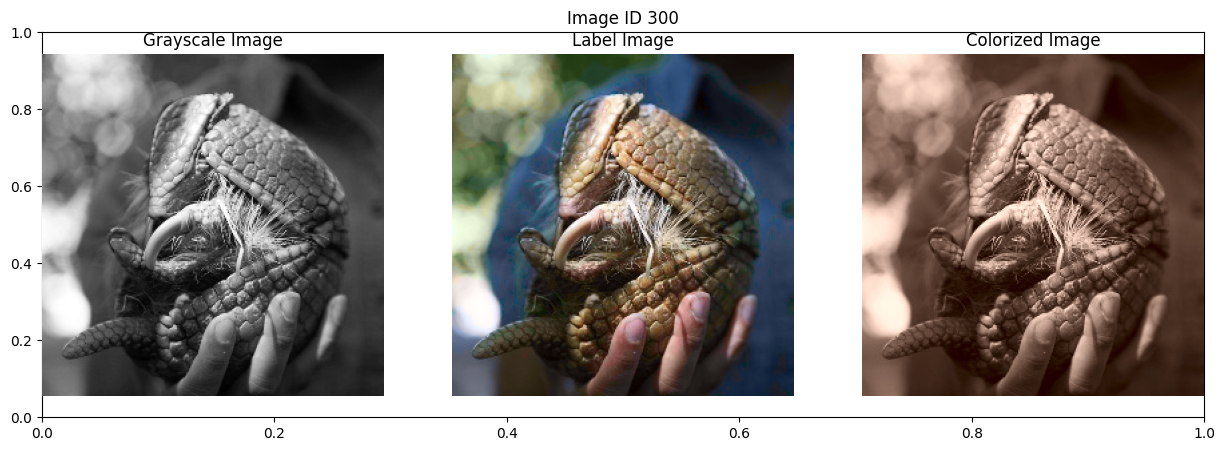

In [ ]:
dataset = train_dataset

model.eval()

# Select a random sample
idx = random.randint(0, len(dataset) - 1)
input_l, target = dataset[idx]

# Grayscale
grayscale_image = to_image(input_l)

target = soft_to_ab(target, used_ab_pairs)

label_image = combine_l_ab(input_l, target)

with torch.no_grad():
    # Forward pass
    input_l = input_l.unsqueeze(0)
    pred_ab_logists = model(input_l)

# convert pred_ab to index

# pred_ab_logists = pred_ab_logists.permute(0, 3, 2, 1)

# pred_ab_index = torch.argmax(pred_ab_logists[0], dim=0)
# print(f'{pred_ab_index.shape=}')

pred_ab = reconstruct_ab(torch.softmax(pred_ab_logists, dim=1),
                         used_ab_pairs)
# pred_ab -= torch.min(pred_ab)
# pred_ab /= torch.max(pred_ab)

# pred_image = combine_l_index_ab(input_l, pred_ab, used_ab_pairs)
pred_image = combine_l_ab(input_l, pred_ab)

# print(f'{target.shape=}')
# print(f'{pred_ab.shape=}')
target_ab = target
# target_ab = convert_index_tensor_to_ab_tensor(target, used_ab_pairs).float()
# pred_ab = convert_index_tensor_to_ab_tensor(pred_ab_index, used_ab_pairs).float()

print(f'TARGET MEAN, STD: {target_ab.mean()}, {target_ab.std()}')
print(f'PREDICTED MEAN, STD: {pred_ab.mean()}, {pred_ab.std()}')

# Plot the images
plt.figure(figsize=(15, 5))

plt.title(f'Image ID {idx}')

plt.subplot(1, 3, 1)
plt.title(f"Grayscale Image")
plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Label Image")
plt.imshow(label_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Colorized Image")
plt.imshow(pred_image)
plt.axis('off')

plt.show()